# Profiling beneficial apps in App Store and Google Play markets



Our goal in this project is to find most profitable App Profiles for Google Play and App Store markets. We're working as data analysts for company that builds Android and iOS applications. Our job is to provide them enough information to make data-driven business decision.

As our company creates only applications that are free to download and install our main income is from ads. That means our revenue for any given app is mostly influenced by the number of users that use our app. Our goal for this project is to analyze data to help our developers understand what kinds of apps are likely to attract more users.

## About the data

As of September 2018, there were approximately 2 million iOS apps available on the App Store, and 2.1 million Android apps on Google Play. Collecting data for over 4 million apps requires a significant amount of time and money, so we'll try to analyze a sample of the data instead.

 We found two free data sets that seem suitable for our goals:

* [A data set](https://www.kaggle.com/lava18/google-play-store-apps) containing data about approximately ten thousand Android apps from Google Play. You can download the data set directly from [this link](https://dq-content.s3.amazonaws.com/350/googleplaystore.csv).

* [A data set](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps) containing data about approximately seven thousand iOS apps from the App Store. You can download the data set directly from [this link](https://dq-content.s3.amazonaws.com/350/AppleStore.csv).

To start let's quickly open these two sets:

In [1]:
from csv import reader

apple_store_csv = open('AppleStore.csv', encoding='utf-8')
apple_store_set = list(reader(apple_store_csv))

google_play_store_csv = open('googleplaystore.csv', encoding='utf-8')
google_play_store_set = list(reader(google_play_store_csv))


To make it easier to explore, we define function which allows us to display slice of set and metadata about it:

In [2]:
def explore_set(dataset, start, end, get_set_metadata=False):
    dataset_slice = dataset[start:end]
    for row in dataset_slice:
        print(row)
        print("\n")
        
    if get_set_metadata:
        print("Number of rows: ", len(dataset))
        print("Number of colums: ", len(dataset[0]))

Now lets check header row and sizes of both sets:

In [3]:
explore_set(apple_store_set, 0, 1, get_set_metadata=True)

['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


Number of rows:  7198
Number of colums:  16


As we see we have 7198 records in set and they are described by 16 columns. For us **price**, **user_rating**, **cont_rating** and **prime_genre** seem the most promising. Some column names are not self-explenator, but details can be found in [documentation](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps).

In [4]:
explore_set(google_play_store_set, 0, 1, get_set_metadata=True)


['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


Number of rows:  10842
Number of colums:  13


As we see our `google_play_store_set` includes more records, but less columns. However if we look at header row, `google_play_store` seems more descriptive. At first glance, interesting columns for us may be ***Category***, ***Rating***, ***Installs***, ***Type***, ***Price*** and ***Genres***.

For future exploration we will separate header and actual data for each set:

In [5]:
android_header, android = google_play_store_set[0], google_play_store_set[1:]
ios_header, ios = apple_store_set[0], apple_store_set[1:]

## Data cleaning

The Google Play data set has a [dedicated discussion section](https://www.kaggle.com/lava18/google-play-store-apps/discussion), and we can see that [one of the discussions](https://www.kaggle.com/lava18/google-play-store-apps/discussion/66015) describes an error for a certain row. 

In [6]:
print(android_header)
print(android[10472])
print("\n")
print("Header length", len(android_header))
print("Row length", len(android[10472]))

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
['Life Made WI-Fi Touchscreen Photo Frame', '1.9', '19', '3.0M', '1,000+', 'Free', '0', 'Everyone', '', 'February 11, 2018', '1.0.19', '4.0 and up']


Header length 13
Row length 12


As we see above, entry 10472 is missing *Category* value. *Category* is crutial for us to create data frequency table. Due to lack of value in this particular entry we will just delete this row.

In [7]:
print(len(android))
del android[10472] # dont run this more than once
print(len(android))

10841
10840


To make sure we work on same structured data we will do aditional check:

In [8]:
header_length = len(android_header)
missmatched_entry_counter = 0
for app in android:
    if len(app) != header_length:
        missmatched_entry_counter += 1
        
print(f'There are {missmatched_entry_counter} missmatched entries.')

There are 0 missmatched entries.


### Duplicated entries

If you explore the Google Play data set long enough or look at the [discussions section](https://www.kaggle.com/lava18/google-play-store-apps/discussion), you'll notice some apps have duplicate entries. For instance, Instagram has four entries:

In [9]:
for app in android:
    name = app[0]
    if name == "Instagram":
        print(app)

['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577446', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66509917', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']


In total there is 1181 duplicated entries:

In [10]:
unique_apps = []
duplicated_apps = []

for app in android:
    name = app[0]
    if name in unique_apps:
        duplicated_apps.append(name)
    else:
        unique_apps.append(name)
        
print(len(duplicated_apps))


1181


Some of duplicated applications are:

In [11]:
print(duplicated_apps[:10])

['Quick PDF Scanner + OCR FREE', 'Box', 'Google My Business', 'ZOOM Cloud Meetings', 'join.me - Simple Meetings', 'Box', 'Zenefits', 'Google Ads', 'Google My Business', 'Slack']


As you can see in *Instagram* example above the diffrence is in fourth column which is *Reviews*.<br/>The different numbers show the data was collected at different times. The higher the number of reviews, the more recent the data should be. This will be our criteria to remove duplicated data.<br/>In order to do that we will:
* Create a dictionary, where each dictionary key is a unique app name and the corresponding dictionary value is the highest number of reviews of that app.
* Use the information stored in the dictionary and create a new data set, which will have only one entry per app (and for each app, we'll only select the entry with the highest number of reviews).

In [12]:
name_and_reviews = {}
for app in android:
    name = app[0]
    n_reviews = float(app[3])
    if name in name_and_reviews and n_reviews > name_and_reviews[name]:
        name_and_reviews[name] = n_reviews
    if name not in name_and_reviews:
        name_and_reviews[name] = n_reviews
# End of part one        

android_clean = [] # our new set
already_added = []
for app in android:
    name = app[0]
    reviews = float(app[3])
    
    if reviews == name_and_reviews[name] and name not in already_added:
            android_clean.append(app)
            already_added.append(name)

You may wondering why we need second list named `already_added`. We need to add this supplementary condition to account for those cases where the highest number of reviews of a duplicate app is the same for more than one entry (for example, the *Box* app has three entries, and the number of reviews is the same). If we just check for `names_and_reviews[name] == reviews`, we'll still end up with duplicate entries for some apps.

To confirm we have all not duplicated entries:

In [13]:
print(len(android) - len(duplicated_apps) == len(android_clean))

True


We don't need to clear the `ios` data set beacuse it contains *id* column which ensures us that we work with unique data.<br/> To confirm that let's check if *ids* are unique:

In [14]:
ids_list = []
for app in ios:
    ids_list.append(app[0])
    
print(len(set(ids_list)) == len(ios))

True


### English-speaking criteria

We use English for the apps we develop at our company, and we'd like to analyze only the apps that are directed toward an English-speaking audience. However, if we explore the data long enough, we'll find that both data sets have apps with names that suggest they are not directed toward an English-speaking audience:

In [15]:
print(ios[6731][1])
print(android_clean[7940][0])

【脱出ゲーム】絶対に最後までプレイしないで 〜謎解き＆ブロックパズル〜
لعبة تقدر تربح DZ


We're not interested in keeping these apps, so we'll remove them. To archieve  that we will define a helper function that checks if name is English. Each character in a string (such as application name) has a corresponding number associated with it. The numbers corresponding to the characters we commonly use in an English text are all in the range 0 to 127, according to the [ASCII](https://en.wikipedia.org/wiki/ASCII) (American Standard Code for Information Interchange) system. Based on this number range, we can build a function that detects whether a character belongs to the set of common English characters or not. If the number is equal to or less than 127, then the character belongs to the set of common English characters.

In [16]:
def is_english_string(string):
    for character in string:
        if ord(character) > 127:
            return False
    return True

print(is_english_string('Instagram'))
print(is_english_string('爱奇艺PPS -《欢乐颂2》电视剧热播'))

True
False


The function seems to work fine, but some English app names use emojis or other symbols (™, — (em dash), – (en dash), etc.) that fall outside of the ASCII range. Because of this, we'll remove useful apps if we use the function in its current form.

In [17]:
print(is_english_string('Docs To Go™ Free Office Suite'))
print(is_english_string('Instachat 😜'))
print("\n")
print(ord('™'))
print(ord('😜'))

False
False


8482
128540


If we're going to use the function we've created, we'll lose useful data since many English apps will be incorrectly labeled as non-English. To minimize the impact of data loss, we'll only remove an app if its name has more than three characters with corresponding numbers falling outside the ASCII range. This means all English apps with up to three emoji or other special characters will still be labeled as English. Our filter function is still not perfect, but it should be fairly effective.

In [18]:
def is_english_string(string):
    non_ascii = 0
    for character in string:
        if ord(character) > 127:
            non_ascii += 1
    
    return non_ascii < 3

In [19]:
print(is_english_string('Docs To Go™ Free Office Suite'))
print(is_english_string('Instachat 😜'))
print(is_english_string('爱奇艺PPS -《欢乐颂2》电视剧热播'))

True
True
False


Now, as our filter is working (at least in terms we accept) we can use it to filter our non-English apps:

In [20]:
android_english = []
ios_english = []

for app in android_clean:
    name = app[0]
    if is_english_string(name):
        android_english.append(app)
        
for app in ios:
    name = app[1]
    if is_english_string(name):
        ios_english.append(app)
        
explore_set(android_english, 0, 3, get_set_metadata=True)
print("\n")
explore_set(ios_english, 0, 3, get_set_metadata=True)


['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']


['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']


Number of rows:  9597
Number of colums:  13


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1']


['529479190', 'Clash of Clans', '116476928', 'USD', '0.0', '2130805', '579', '4.5', '4.5', '9.24.12', '9+',

We can see that we're left with 9597 Android apps and 6155 iOS apps.

So far in the data cleaning process, we:
* Removed inaccurate data
* Removed duplicate app entries
* Removed non-English apps

As we mentioned in the introduction, we only build apps that are free to download and install, and our main source of revenue consists of in-app ads. Our data sets contain both free and non-free apps; we'll need to isolate only the free apps for our analysis. This will be our last step in data cleaning.

### Isolating free apps

In [21]:
ios_final = []
android_final = []

for app in android_english:
    price = app[7]
    if price == '0':
        android_final.append(app)
        
for app in ios_english:
    price = app[4]
    if price == '0.0':
        ios_final.append(app)
        
print(len(android_final))
print(len(ios_final))
        

8848
3203


We're left with 8844 Android apps and 3203 iOS apps, which should be enough for our analysis.

## Most popular apps by Genre

As we mentioned in the introduction, our aim is to determine the kinds of apps that are likely to attract more users because our revenue is highly influenced by the number of people using our apps.

To minimize risks and overhead, our validation strategy for an app idea is comprised of three steps:

1. Build a minimal Android version of the app, and add it to Google Play.
2. If the app has a good response from users, we develop it further.
3. If the app is profitable after six months, we build an iOS version of the app and add it to the App Store.

Because our end goal is to add the app on both Google Play and the App Store, we need to find app profiles that are successful on both markets. For instance, a profile that works well for both markets might be a productivity app that makes use of gamification.

Let's begin the analysis by getting a sense of what are the most common genres for each market. For this, we'll need to build frequency tables. For App Store we will use *prime_genre* column. For Google Play we will create two: based on *Category* and based on *Genres* column.

We'll build two functions to analyze the frequency tables:

* One function to generate frequency tables that show percentages
* Another function we can use to display the percentages in a descending order


In [22]:
def freq_table(dataset, index):
    table = {}
    
    for row in dataset:
        value = row[index]
        if value in table:
            table[value] += 1
        else:
            table[value] = 1
            
    table_percentages = {}
    for key in table:
        percentage = (table[key] / len(dataset)) * 100
        table_percentages[key] = percentage
        
    return table_percentages

In [23]:
def display_table(dataset, index):
    table = freq_table(dataset, index)
    table_display = []
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_display.append(key_val_as_tuple)
        
    table_sorted = sorted(table_display, reverse = True)
    for entry in table_sorted:
        print(entry[1], ':', entry[0])

As we have our funcions let's display frequency tables of interesting for us columns:

#### iOS by prime genre

In [24]:
display_table(ios_final, 11)

Games : 58.25788323446769
Entertainment : 7.836403371838902
Photo & Video : 4.995316890415236
Education : 3.6840462066812365
Social Networking : 3.3093974399000934
Shopping : 2.5913206369029034
Utilities : 2.466437714642523
Sports : 2.1542304089915705
Music : 2.0605682172962845
Health & Fitness : 2.0293474867311896
Productivity : 1.7483609116453322
Lifestyle : 1.5610365282547611
News : 1.3424914142990947
Travel : 1.248829222603809
Finance : 1.0927255697783327
Weather : 0.8741804558226661
Food & Drink : 0.8117389946924758
Reference : 0.5307524196066188
Business : 0.5307524196066188
Book : 0.3746487667811427
Navigation : 0.18732438339057134
Medical : 0.18732438339057134
Catalogs : 0.1248829222603809


As we see more than half, exactly 55,6%, of free English apps in App Store are Games. Entertaiment is the major runner-up with result of 8% percentage.<br/><br/>
As we see there is a huge gap between them. If we consider *Games* and *Entertainment* as genres which primary purpose is entertainment we can see that more than it hold 60% of market. However, the fact that fun apps are the most numerous doesn't also imply that they also have the greatest number of users — the demand might not be the same as the offer.<br/><br/>
Let's continue by examining the Genres and Category columns of the Google Play data set (two columns which seem to be related).

### Android by Category

In [25]:
display_table(android_final, 1)

FAMILY : 18.942133815551536
GAME : 9.697106690777577
TOOLS : 8.453887884267631
BUSINESS : 4.599909584086799
PRODUCTIVITY : 3.899186256781193
LIFESTYLE : 3.887884267631103
FINANCE : 3.7070524412296564
MEDICAL : 3.5375226039783
SPORTS : 3.390596745027125
PERSONALIZATION : 3.322784810126582
COMMUNICATION : 3.2323688969258586
HEALTH_AND_FITNESS : 3.0854430379746836
PHOTOGRAPHY : 2.949819168173599
NEWS_AND_MAGAZINES : 2.802893309222423
SOCIAL : 2.667269439421338
TRAVEL_AND_LOCAL : 2.3395117540687163
SHOPPING : 2.2490958408679926
BOOKS_AND_REFERENCE : 2.1360759493670884
DATING : 1.8648282097649187
VIDEO_PLAYERS : 1.7970162748643763
MAPS_AND_NAVIGATION : 1.3901446654611211
FOOD_AND_DRINK : 1.2432188065099457
EDUCATION : 1.164104882459313
ENTERTAINMENT : 0.9606690777576853
LIBRARIES_AND_DEMO : 0.9380650994575045
AUTO_AND_VEHICLES : 0.9267631103074141
HOUSE_AND_HOME : 0.8024412296564195
WEATHER : 0.7911392405063291
EVENTS : 0.7120253164556962
PARENTING : 0.6555153707052441
ART_AND_DESIGN : 0.64

The overall impression is siginificantly diffrent. Game category which includes more than half apps in App Store, in Google Play has only 8%.<br/>What is more, as we can see there are not many apps designed for fun. The top includes apps for practical purposes (such as tools, businnss, productivity, finance, lifestyle, medical).<br/> What may be confisuing is *Family* category (which accounts almost 19% of the apps), however if we investigate Google Play we will find out that mostly it means games for kids.

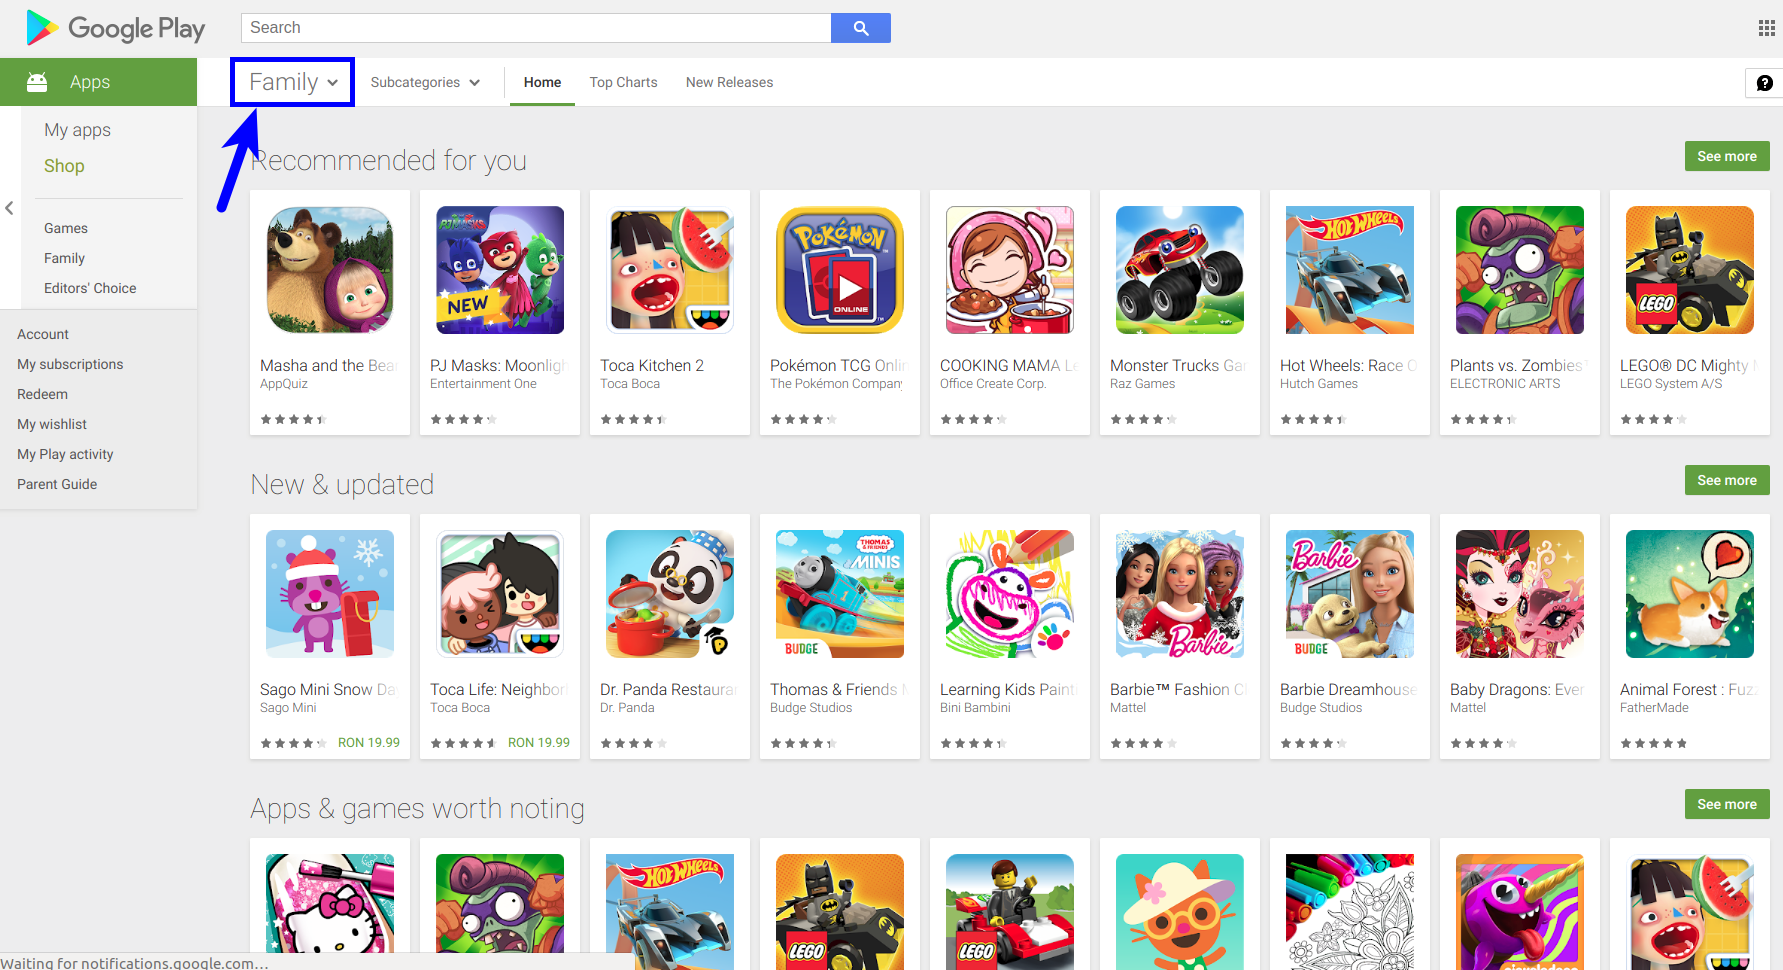

Even so, practical apps seem to have a better represenatation on Google Play compared to App Sore. This is also confimed by the frequency table we see for the *Genres* column:

### Android by Genre

In [26]:
display_table(android_final, 9)

Tools : 8.44258589511754
Entertainment : 6.080470162748644
Education : 5.357142857142857
Business : 4.599909584086799
Productivity : 3.899186256781193
Lifestyle : 3.8765822784810124
Finance : 3.7070524412296564
Medical : 3.5375226039783
Sports : 3.4584086799276674
Personalization : 3.322784810126582
Communication : 3.2323688969258586
Action : 3.096745027124774
Health & Fitness : 3.0854430379746836
Photography : 2.949819168173599
News & Magazines : 2.802893309222423
Social : 2.667269439421338
Travel & Local : 2.328209764918626
Shopping : 2.2490958408679926
Books & Reference : 2.1360759493670884
Simulation : 2.0456600361663653
Dating : 1.8648282097649187
Arcade : 1.842224231464738
Video Players & Editors : 1.7744122965641953
Casual : 1.763110307414105
Maps & Navigation : 1.3901446654611211
Food & Drink : 1.2432188065099457
Puzzle : 1.1301989150090417
Racing : 0.9945750452079566
Role Playing : 0.9380650994575045
Libraries & Demo : 0.9380650994575045
Auto & Vehicles : 0.9267631103074141
St

The diffrence between *Genres* and *Category* column may be not clear, but one thing we can perceive at a glance is that *Genres* column is much mor granular (it has multiple categories). As we looking for big picture it seems that *Category* column is more suitable for us, so we will use that in our future considerations.

So far, our general conclusions are that App Store is dominanted by apps designed for fun, while Google Play is way more balanced and top positions are mostly practical purpose applications.<br/><br/> However, number of applications in some category doesn't implicate that this is best choice for us. To get better picture, we should consider how popular applications are among users. One way to find out what genres are the most popular (have the most users) is to calculate the average number of installs for each app genre. In Google Play set we can find column *Installs*, which indicates number of installations. We don't have analogous column in App Store set, but for our approximation we can use *rating_count_tot* which is number of ratings users left. It is not perfect comparision but it is the best we can get.

To get job done in Apple Store set we need to count number of reviews per *prime_genre*. We can get unique genres from our frequency table:

In [27]:
genres_ios = freq_table(ios_final, -5)

In [28]:
for genre in genres_ios:
    total = 0
    len_genre = 0
    for row in ios_final:
        genre_app = row[-5]
        if genre_app == genre:
            num_of_ratings = float(row[5])
            total += num_of_ratings
            len_genre += 1
            
    print(f'{genre}: {total/len_genre}')


Social Networking: 71548.34905660378
Photo & Video: 28441.54375
Games: 22886.36709539121
Music: 57326.530303030304
Reference: 79350.4705882353
Health & Fitness: 23298.015384615384
Weather: 52279.892857142855
Utilities: 19156.493670886077
Travel: 28243.8
Shopping: 27230.734939759037
News: 21248.023255813954
Navigation: 86090.33333333333
Lifestyle: 16815.48
Entertainment: 14195.358565737051
Food & Drink: 33333.92307692308
Sports: 23008.898550724636
Book: 46384.916666666664
Finance: 32367.02857142857
Education: 7003.983050847458
Productivity: 21028.410714285714
Business: 7491.117647058823
Catalogs: 4004.0
Medical: 612.0


As we see the most reviewed *prime_genres* is *Music* they are heavily influenced by Spotify and Pandora.

In [29]:
for app in ios_final:
    if app[-5] == 'Music':
        print(app[1], ':', app[5])

Pandora - Music & Radio : 1126879
Spotify Music : 878563
Shazam - Discover music, artists, videos & lyrics : 402925
iHeartRadio – Free Music & Radio Stations : 293228
SoundCloud - Music & Audio : 135744
Magic Piano by Smule : 131695
Smule Sing! : 119316
TuneIn Radio - MLB NBA Audiobooks Podcasts Music : 110420
Amazon Music : 106235
SoundHound Song Search & Music Player : 82602
Sonos Controller : 48905
Bandsintown Concerts : 30845
Karaoke - Sing Karaoke, Unlimited Songs! : 28606
My Mixtapez Music : 26286
Sing Karaoke Songs Unlimited with StarMaker : 26227
Ringtones for iPhone & Ringtone Maker : 25403
Musi - Unlimited Music For YouTube : 25193
AutoRap by Smule : 18202
Spinrilla - Mixtapes For Free : 15053
Napster - Top Music & Radio : 14268
edjing Mix:DJ turntable to remix and scratch music : 13580
Free Music - MP3 Streamer & Playlist Manager Pro : 13443
Free Piano app by Yokee : 13016
Google Play Music : 10118
Certified Mixtapes - Hip Hop Albums & Mixtapes : 9975
TIDAL : 7398
YouTube Mu

 *Social Networking* is genre in which includes majors like Pinterest and Facebook.

In [30]:
for app in ios_final:
    if app[-5] == 'Social Networking':
        print(app[1], ':', app[5])

Facebook : 2974676
Pinterest : 1061624
Skype for iPhone : 373519
Messenger : 351466
Tumblr : 334293
WhatsApp Messenger : 287589
Kik : 260965
ooVoo – Free Video Call, Text and Voice : 177501
TextNow - Unlimited Text + Calls : 164963
Viber Messenger – Text & Call : 164249
Followers - Social Analytics For Instagram : 112778
MeetMe - Chat and Meet New People : 97072
We Heart It - Fashion, wallpapers, quotes, tattoos : 90414
InsTrack for Instagram - Analytics Plus More : 85535
Tango - Free Video Call, Voice and Chat : 75412
LinkedIn : 71856
Match™ - #1 Dating App. : 60659
Skype for iPad : 60163
POF - Best Dating App for Conversations : 52642
Timehop : 49510
Find My Family, Friends & iPhone - Life360 Locator : 43877
Whisper - Share, Express, Meet : 39819
Hangouts : 36404
LINE PLAY - Your Avatar World : 34677
WeChat : 34584
Badoo - Meet New People, Chat, Socialize. : 34428
Followers + for Instagram - Follower Analytics : 28633
GroupMe : 28260
Marco Polo Video Walkie Talkie : 27662
Miitomo : 2

 *Games* aren't dominant here, but it is still decent. Suprisingly, *Weather* have over 47k average ratings, with only 0.3% of Apple Store market (at least part of it which we analyze), which make impression that there is a lot attention over a very little amount of applications, which may be our key. Let's quickly investigate this genre.

In [31]:
for app in ios_final:
    if app[-5] == 'Weather':
        print(app[1], ':', app[5])


The Weather Channel: Forecast, Radar & Alerts : 495626
The Weather Channel App for iPad – best local forecast, radar map, and storm tracking : 208648
WeatherBug - Local Weather, Radar, Maps, Alerts : 188583
MyRadar NOAA Weather Radar Forecast : 150158
AccuWeather - Weather for Life : 144214
Yahoo Weather : 112603
Weather Underground: Custom Forecast & Local Radar : 49192
NOAA Weather Radar - Weather Forecast & HD Radar : 45696
Weather Live Free - Weather Forecast & Alerts : 35702
Storm Radar : 22792
QuakeFeed Earthquake Map, Alerts, and News : 6081
Moji Weather - Free Weather Forecast : 2333
Hurricane by American Red Cross : 1158
Forecast Bar : 375
Hurricane Tracker WESH 2 Orlando, Central Florida : 203
FEMA : 128
iWeather - World weather forecast : 80
Weather - Radar - Storm with Morecast App : 78
Yurekuru Call : 53
Weather & Radar : 37
WRAL Weather Alert : 25
Météo-France : 24
JaxReady : 22
Freddy the Frogcaster's Weather Station : 14
Almanac Long-Range Weather Forecast : 12
TodayAir

We have data about the number of installs for the Google Play market, so we should be able to get a clearer picture about genre popularity. However, the install numbers don't seem precise enough — we can see that most values are open-ended (100+, 1,000+, 5,000+, etc.):

In [32]:
display_table(android_final, 5)

1,000,000+ : 15.75497287522604
100,000+ : 11.539330922242314
10,000,000+ : 10.567359855334539
10,000+ : 10.194394213381555
1,000+ : 8.39737793851718
100+ : 6.928119349005425
5,000,000+ : 6.826401446654612
500,000+ : 5.560578661844485
50,000+ : 4.769439421338156
5,000+ : 4.486889692585895
10+ : 3.5375226039783
500+ : 3.2436708860759493
50,000,000+ : 2.2830018083182644
100,000,000+ : 2.1360759493670884
50+ : 1.9213381555153706
5+ : 0.7911392405063291
1+ : 0.5085895117540687
500,000,000+ : 0.27124773960216997
1,000,000,000+ : 0.22603978300180833
0+ : 0.045207956600361664
0 : 0.011301989150090416


We don't know whether an app with 100,000+ installs has 100,000 installs, 200,000, or 350,000. However, we don't need very precise data for our purposes — we only want to find out which app genres attract the most users, and we don't need perfect precision with respect to the number of users.

We're going to leave the numbers as they are, which means that we'll consider that an app with 100,000+ installs has 100,000 installs, and an app with 1,000,000+ installs has 1,000,000 installs, and so on. To perform computations, however we'll need to parse this data. This means we need to remove the commas and the plus characters. What is more because these numbers are enormous, the average also will be huge so we will sort it to get better picture.

In [43]:
categories_android = freq_table(android_clean, 1)

for category in categories_android:
    total = 0
    len_category = 0
    for row in android_clean:
        category_app = row[1]
        if category_app == category:
            num_of_installs = row[5]
            num_of_installs = num_of_installs.replace("+", "").replace(',', '')
            total += float(num_of_installs)
            len_category += 1
    
    print(f'{category}: {total/len_category}')

ART_AND_DESIGN: 1856362.2950819673
AUTO_AND_VEHICLES: 625061.305882353
BEAUTY: 513151.88679245283
BOOKS_AND_REFERENCE: 7504367.459459459
BUSINESS: 1659916.3452380951
COMICS: 803234.8214285715
COMMUNICATION: 35042146.82857143
DATING: 828971.2176470588
EDUCATION: 1775252.3364485982
ENTERTAINMENT: 11375402.298850575
EVENTS: 249580.640625
FINANCE: 1319851.4028985507
FOOD_AND_DRINK: 1891060.2767857143
HEALTH_AND_FITNESS: 3972300.388888889
HOUSE_AND_HOME: 1331540.5616438356
LIBRARIES_AND_DEMO: 630903.6904761905
LIFESTYLE: 1365375.4444444445
GAME: 14226135.745243128
FAMILY: 3319926.0965848453
MEDICAL: 96944.49873417722
SOCIAL: 22961790.384937238
SHOPPING: 6932419.727722772
PHOTOGRAPHY: 16577037.918149466
SPORTS: 3373767.6861538463
TRAVEL_AND_LOCAL: 13218662.767123288
TOOLS: 9774151.887816647
PERSONALIZATION: 4075783.994680851
PRODUCTIVITY: 15489549.114973262
PARENTING: 525351.8333333334
WEATHER: 4570892.658227848
VIDEO_PLAYERS: 23975016.585365854
NEWS_AND_MAGAZINES: 9327628.976377953
MAPS_AND

On average, communication apps have the most installs: 38,456,119. This number is heavily skewed up by a few apps that have over one billion installs (WhatsApp, Facebook Messenger, Skype, Google Chrome, Gmail, and Hangouts), and a few others with over 100 and 500 million installs:

In [34]:
for app in android_final:
    if app[1] == 'COMMUNICATION' and (app[5] == '1,000,000,000+'
                                      or app[5] == '500,000,000+'
                                      or app[5] == '100,000,000+'):
        print(app[0], ':', app[5])

WhatsApp Messenger : 1,000,000,000+
imo beta free calls and text : 100,000,000+
Android Messages : 100,000,000+
Google Duo - High Quality Video Calls : 500,000,000+
Messenger – Text and Video Chat for Free : 1,000,000,000+
imo free video calls and chat : 500,000,000+
Skype - free IM & video calls : 1,000,000,000+
Who : 100,000,000+
GO SMS Pro - Messenger, Free Themes, Emoji : 100,000,000+
LINE: Free Calls & Messages : 500,000,000+
Google Chrome: Fast & Secure : 1,000,000,000+
Firefox Browser fast & private : 100,000,000+
UC Browser - Fast Download Private & Secure : 500,000,000+
Gmail : 1,000,000,000+
Hangouts : 1,000,000,000+
Messenger Lite: Free Calls & Messages : 100,000,000+
Kik : 100,000,000+
KakaoTalk: Free Calls & Text : 100,000,000+
Opera Mini - fast web browser : 100,000,000+
Opera Browser: Fast and Secure : 100,000,000+
Telegram : 100,000,000+
Truecaller: Caller ID, SMS spam blocking & Dialer : 100,000,000+
UC Browser Mini -Tiny Fast Private & Secure : 100,000,000+
Viber Mess

Second biggest are *VIDEO_PLAYERS*:

In [37]:
for app in android_final:
    if app[1] == 'VIDEO_PLAYERS' and (app[5] == '1,000,000,000+'
                                      or app[5] == '500,000,000+'
                                      or app[5] == '100,000,000+'):
        print(app[0], ':', app[5])
        

YouTube : 1,000,000,000+
Motorola Gallery : 100,000,000+
VLC for Android : 100,000,000+
Google Play Movies & TV : 1,000,000,000+
MX Player : 500,000,000+
Dubsmash : 100,000,000+
VivaVideo - Video Editor & Photo Movie : 100,000,000+
VideoShow-Video Editor, Video Maker, Beauty Camera : 100,000,000+
Motorola FM Radio : 100,000,000+


As we can see in this category Youtube has a monopoly. Third place is *SOCIAL*, which as in Apple Store is dominated by Facebook.

The interesting for us category may be *TRAVEL_AND_LOCAL* which is 7th (was 9th in App Store)

In [41]:
for app in android_final:
    if app[1] == 'TRAVEL_AND_LOCAL' and (app[5] == '1,000,000,000+'
                                      or app[5] == '500,000,000+'
                                      or app[5] == '100,000,000+'):
        print(app[0], ':', app[5])

Booking.com Travel Deals : 100,000,000+
TripAdvisor Hotels Flights Restaurants Attractions : 100,000,000+
Maps - Navigate & Explore : 1,000,000,000+
Google Street View : 1,000,000,000+
Google Earth : 100,000,000+


As we see in Google Play this category also includes Google Maps (which were classified in *Navigation* genre on App Store), but despite that there are only two majors with 100.000.000+ installs. Let's investigate this on App Store:

In [45]:
for app in ios_final:
    if app[-5] == 'Travel':
        print(app[1], ':', app[5])


Google Earth : 446185
Yelp - Nearby Restaurants, Shopping & Services : 223885
GasBuddy : 145549
TripAdvisor Hotels Flights Restaurants : 56194
Uber : 49466
Lyft : 46922
HotelTonight - Great Deals on Last Minute Hotels : 32341
Hotels & Vacation Rentals by Booking.com : 31261
Southwest Airlines : 30552
Airbnb : 22302
Expedia Hotels, Flights & Vacation Package Deals : 10278
Fly Delta : 8094
Hopper - Predict, Watch & Book Flights : 6944
United Airlines : 5748
Skiplagged — Actually Cheap Flights & Hotels : 1851
Viator Tours & Activities : 1839
iExit Interstate Exit Guide : 1798
Gogo Entertainment : 1482
Google Street View : 1450
Webcams – EarthCam : 912
HISTORY Here : 685
DB Navigator : 512
Mobike - Dockless Bike Share : 494
MiFlight™ – Airport security line wait times at checkpoints for domestic and international travelers : 493
BlaBlaCar - Trusted Carpooling : 397
Six Flags : 353
Google Trips – Travel planner : 329
Voyages-sncf.com : book train and bus tickets : 268
Trainline UK: Live Tra